In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess



In [2]:
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# Define image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 50

In [4]:
# Function to split dataset into train, validation, and test sets
def split_data(base_dir):
    all_data = []
    categories = os.listdir(base_dir)
    for category in categories:
        category_path = os.path.join(base_dir, category)
        images = os.listdir(category_path)
        for img in images:
            img_path = os.path.join(category_path, img)
            all_data.append((img_path, category))
    
    # Convert to numpy array for easier splitting
    all_data = np.array(all_data)
    train_data, test_data = train_test_split(all_data, test_size=0.2, stratify=all_data[:, 1])
    train_data, val_data = train_test_split(train_data, test_size=0.20, stratify=train_data[:, 1])
    
    return train_data, val_data, test_data

In [5]:
# Function to prepare data generators
def prepare_data_generators(train_data, val_data, test_data, class_indices):
    datagen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)

    def create_generator(data, datagen):
        x, y = zip(*data)
        x = np.array([np.array(Image.open(img).resize(IMG_SIZE)) for img in x])
        y = np.array([class_indices[label] for label in y])
        y = to_categorical(y, num_classes=len(class_indices))
        return datagen.flow(x, y, batch_size=BATCH_SIZE, shuffle=False)

    train_generator = create_generator(train_data, datagen)
    val_generator = create_generator(val_data, datagen)
    test_generator = create_generator(test_data, datagen)

    return train_generator, val_generator, test_generator

In [6]:
# Function to build the model using DenseNet169
def build_model(input_shape, num_classes):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [7]:
# Function to evaluate the model
def evaluate_model(model, test_generator, true_labels, class_indices):
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f'Test Accuracy: {test_accuracy:.2f}')

    test_generator.reset()
    batch_size = test_generator.batch_size
    steps = None  # Iterate indefinitely over the data until steps_per_epoch is reached

    predictions = model.predict(test_generator, steps=steps)
    num_samples = len(predictions)
    predicted_labels = np.argmax(predictions, axis=1)

    class_labels = list(class_indices.keys())

    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print('Classification Report:')
    print(report)

    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print('Confusion Matrix:')
    print(conf_matrix)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [8]:
# Function to generate saliency maps
def generate_saliency_map(model, img_array, class_index):
    img_array = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        tape.watch(img_array)
        predictions = model(img_array)
        loss = predictions[:, class_index]
    gradients = tape.gradient(loss, img_array)
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)
    return saliency[0]

In [9]:
# Function to generate Grad-CAM
def get_gradcam_model(model, layer_name):
    mob_model = model.get_layer('mobilenetv2_1.00_224')
    conv_layer = mob_model.get_layer(layer_name).output
    grad_model = Model(inputs=model.inputs, outputs=[conv_layer, model.output])
    return grad_model

def generate_gradcam_heatmap(grad_model, img_array, class_idx, pred_index=None):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = np.array(Image.open(img_path).resize(IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img


In [10]:
# Main training and evaluation loop for each dataset
base_path = './DatasetMark2'

train_data, val_data, test_data = split_data(base_path)

# Determine class indices from the dataset
class_indices = {category: idx for idx, category in enumerate(os.listdir(base_path))}
num_classes = len(class_indices)

train_generator, val_generator, test_generator = prepare_data_generators(train_data, val_data, test_data, class_indices)

input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)

model = build_model(input_shape, num_classes)
model.summary()

# Dummy call to build the model
dummy_input = np.zeros((1, IMG_SIZE[0], IMG_SIZE[1], 3))
model.predict(dummy_input)

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [11]:

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50
   1/1707 ━━━━━━━━━━━━━━━━━━━━ 2:42:25 6s/step - accuracy: 0.4375 - loss: 1.1353

d:\MaizeWork\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1707/1707 ━━━━━━━━━━━━━━━━━━━━ 207s 118ms/step - accuracy: 0.8245 - loss: 0.4037 - val_accuracy: 0.8641 - val_loss: 0.3126 - learning_rate: 0.0010
Epoch 2/50
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 202s 118ms/step - accuracy: 0.8648 - loss: 0.3193 - val_accuracy: 0.8695 - val_loss: 0.3035 - learning_rate: 0.0010
Epoch 3/50
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 201s 118ms/step - accuracy: 0.8718 - loss: 0.2993 - val_accuracy: 0.8682 - val_loss: 0.3079 - learning_rate: 0.0010
Epoch 4/50
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 199s 116ms/step - accuracy: 0.8786 - loss: 0.2876 - val_accuracy: 0.8740 - val_loss: 0.2955 - learning_rate: 0.0010
Epoch 5/50
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 204s 119ms/step - accuracy: 0.8810 - loss: 0.2825 - val_accuracy: 0.8658 - val_loss: 0.3121 - learning_rate: 0.0010
Epoch 6/50
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 203s 119ms/step - accuracy: 0.8892 - loss: 0.2651 - val_accuracy: 0.8712 - val_loss: 0.3020 - learning_rate: 0.0010
Epoch 7/50
1707/1707 ━━━━━━━━━━━━━━━━━━━━ 211s 124ms/step - acc

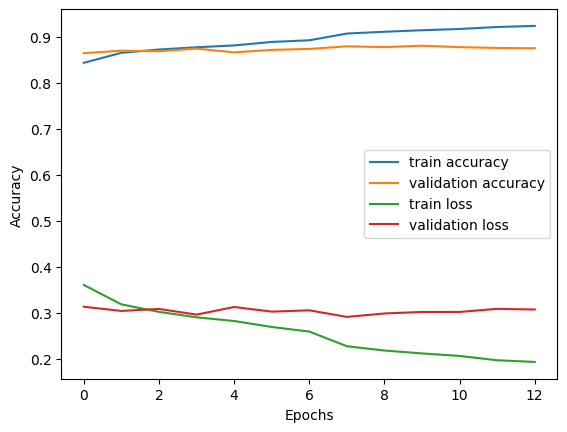

In [12]:
# Plot training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

534/534 ━━━━━━━━━━━━━━━━━━━━ 46s 86ms/step - accuracy: 0.8774 - loss: 0.2893
Test Accuracy: 0.88
534/534 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.88      0.88      8709
    positive       0.88      0.87      0.87      8357

    accuracy                           0.88     17066
   macro avg       0.88      0.88      0.88     17066
weighted avg       0.88      0.88      0.88     17066

Confusion Matrix:
[[7687 1022]
 [1098 7259]]


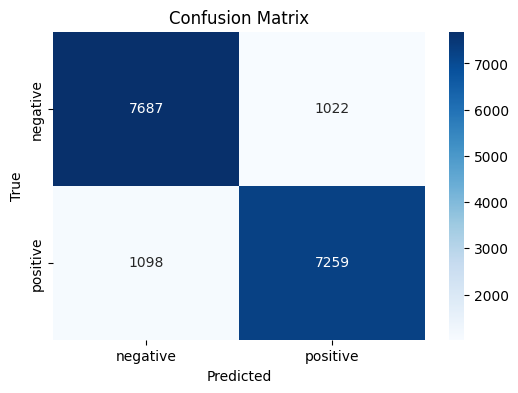

In [13]:
# Extract true labels for evaluation
true_labels = np.array([class_indices[label] for (_, label) in test_data])
# Evaluate the model
evaluate_model(model, test_generator, true_labels, class_indices)

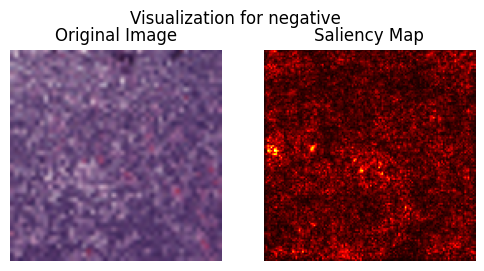

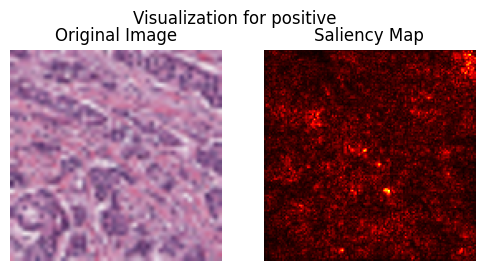

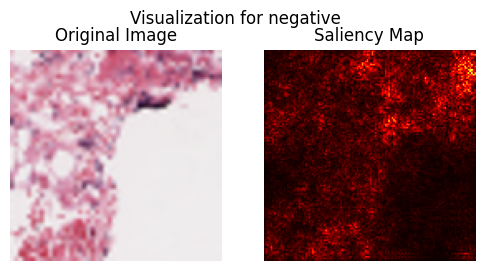

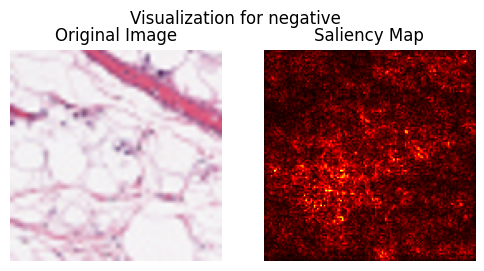

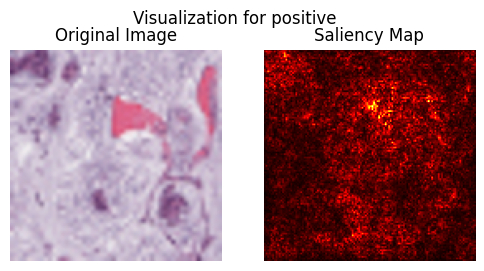

In [14]:

# Saliency maps and attention visualizations
# last_conv_layer_name = 'block_16_project'  # Adjust based on DenseNet169 last conv layer
# grad_model = get_gradcam_model(model, last_conv_layer_name)

for img_path, true_label in test_data[:5]:  # Visualize for first 5 test images
    img_array = np.expand_dims(np.array(Image.open(img_path).resize(IMG_SIZE)) / 255.0, axis=0)
    class_index = class_indices[true_label]

    # Generate saliency map
    saliency = generate_saliency_map(model, img_array, class_index)

    # Generate Grad-CAM
    # heatmap = generate_gradcam_heatmap(grad_model, img_array, class_index, last_conv_layer_name)

    # Display images
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    # Original image
    original_img = np.array(Image.open(img_path).resize(IMG_SIZE))
    axes[0].imshow(original_img)
    axes[0].axis('off')
    axes[0].set_title('Original Image')
    
    # Saliency map
    axes[1].imshow(saliency, cmap='hot')
    axes[1].axis('off')
    axes[1].set_title('Saliency Map')
    
    # # Grad-CAM
    # gradcam_img = display_gradcam(img_path, heatmap)
    # axes[2].imshow(gradcam_img)
    # axes[2].axis('off')
    # axes[2].set_title('Grad-CAM')
    
    plt.suptitle(f'Visualization for {true_label}')
    plt.show()

In [15]:
tf.keras.models.save_model(model,'mobNew.h5')